<a href="https://colab.research.google.com/github/Clementlecoz/Internship_finance_AI/blob/main/Ml_learning_anomalies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd


# Remplace ici par le bon nom du fichier après upload
df = pd.read_csv("dataset_unified.csv", sep=";")


In [ ]:
# 🔹 Colonnes à convertir en float (remplacer ',' par '.')
features = [
    'ROA', 'ROE', 'debt_to_equity', 'current_ratio', 'net_margin',
    'revenue_growth', 'cash_ratio', 'inflation_YoY', 'gdp_growth_rate', 'interest_rate'
]

# Conversion texte → float
for col in features:
    df[col] = df[col].astype(str).str.replace(',', '.').astype(float)

# 🔹 Filtrage : ne garder que Banco Santander
df_banco = df[df["company"] == "JP Morgan Chase"].copy()

# 🔹 Date → datetime et tri
df_banco["date"] = pd.to_datetime(df_banco["date"])
df_banco = df_banco.sort_values(by="date")

# 🔹 Interpolation temporelle
df_banco[features] = df_banco[features].interpolate(method="linear", limit_direction="both")

# 🔹 Sécurité : remplissage final
df_banco[features] = df_banco[features].fillna(method='ffill').fillna(method='bfill')


/tmp/ipython-input-6-3242765617.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_banco[features] = df_banco[features].fillna(method='ffill').fillna(method='bfill')


Per-feature

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam

def train_autoencoder(X, encoding_dim=2, epochs=100, batch_size=8):
    input_dim = X.shape[1]
    input_layer = Input(shape=(input_dim,))

    # Encodeur
    encoded = Dense(encoding_dim * 2, activation='relu')(input_layer)
    encoded = Dense(encoding_dim, activation='relu')(encoded)

    # Décodeur
    decoded = Dense(encoding_dim * 2, activation='relu')(encoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    autoencoder.fit(X, X, epochs=epochs, batch_size=batch_size, verbose=0)
    return autoencoder


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Exemples de groupes
groups = {
    "rentabilité": ["ROE", "ROA", "net_margin"],
    "solvabilité": ["debt_to_equity", "current_ratio"],
    "liquidité": ["cash_ratio"],
    "croissance": ["revenue_growth"]
}

autoencoders = {}
reconstruction_errors = {}

for group_name, cols in groups.items():
    print(f"▶️ Training AutoEncoder for {group_name}")

    # Normalisation
    scaler = StandardScaler()
    X_group = scaler.fit_transform(df_banco[cols])

    # Entraînement
    ae = train_autoencoder(X_group, encoding_dim=min(2, len(cols)))
    autoencoders[group_name] = ae

    # Reconstruction
    X_rec = ae.predict(X_group)
    mse = np.mean(np.square(X_group - X_rec), axis=1)
    reconstruction_errors[group_name] = mse


▶️ Training AutoEncoder for rentabilité
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
▶️ Training AutoEncoder for solvabilité
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
▶️ Training AutoEncoder for liquidité
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
▶️ Training AutoEncoder for croissance
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


In [ ]:
# Fusion dans un DataFrame
df_group_errors = pd.DataFrame(reconstruction_errors)
df_group_errors["date"] = df_banco["date"].values
df_group_errors["company"] = df_banco["company"].values

# Ajoute une colonne "anomalie_detectée"
for group in groups:
    threshold = np.percentile(df_group_errors[group], 95)
    df_group_errors[f"is_anomaly_{group}"] = df_group_errors[group] > threshold

# Aperçu
print(df_group_errors.head())


   rentabilité  solvabilité  liquidité  croissance       date  \
0     0.686721     0.029914   0.086656    2.870249 2012-03-31   
1     0.781599     0.002396   0.315990    0.000105 2012-06-30   
2     0.414658     0.026553   0.086656    0.458266 2012-09-30   
3     0.119472     0.014022   0.058149    0.017903 2012-12-31   
4     0.030092     0.013136   0.258976    0.034112 2013-03-31   

           company  is_anomaly_rentabilité  is_anomaly_solvabilité  \
0  JP Morgan Chase                   False                   False   
1  JP Morgan Chase                   False                   False   
2  JP Morgan Chase                   False                   False   
3  JP Morgan Chase                   False                   False   
4  JP Morgan Chase                   False                   False   

   is_anomaly_liquidité  is_anomaly_croissance  
0                 False                   True  
1                 False                  False  
2                 False                  

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd

df_events_jpm = pd.DataFrame([
    {"date":"2012-07-01", "event":"London Whale (perte ~$6 Md)", "target":"rentabilité"},
    {"date":"2013-09-19", "event":"Amende FCA London Whale (~£137 M)", "target":"rentabilité"},
    {"date":"2013-12-01", "event":"Règlement $13 Md avec le DOJ (subprimes)", "target":"rentabilité/solvabilité"},
    {"date":"2015-06-30", "event":"Charges exceptionnelles / règlements légaux 2015", "target":"rentabilité"},
    {"date":"2016-09-08", "event":"Amende FCPA Asie ($200 M)", "target":"rentabilité/solvabilité"},
    {"date":"2018-01-12", "event":"Profits records post-réforme fiscale Trump", "target":"rentabilité/croissance"},
    {"date":"2020-03-31", "event":"Crise Covid‑19 (liquidité & provisions)", "target":"rentabilité/liquidité/croissance"},
    {"date":"2021-09-30", "event":"Profits records Q3 2021", "target":"rentabilité"},
    {"date":"2022-03-31", "event":"Tensions géopolitiques / remontée taux", "target":"solvabilité"},
    {"date":"2022-10-15", "event":"Hausse revenus nets d’intérêts (taux Fed)", "target":"rentabilité/croissance"},
    {"date":"2023-05-01", "event":"Rachat First Republic Bank", "target":"croissance/solvabilité"},
    {"date":"2023-12-31", "event":"Profit record Q4 2023", "target":"rentabilité"},
    {"date":"2024-03-31", "event":"Amende CFTC/OCC 2024 (~$350 M)", "target":"solvabilité"},
    {"date":"2024-10-02", "event":"Gel $372 M actifs en Russie", "target":"liquidité"},
    {"date":"2025-01-14", "event":"Whistleblower (sous-capitalisation)", "target":"solvabilité/rentabilité"},
])
df_events_jpm['date'] = pd.to_datetime(df_events_jpm['date'])



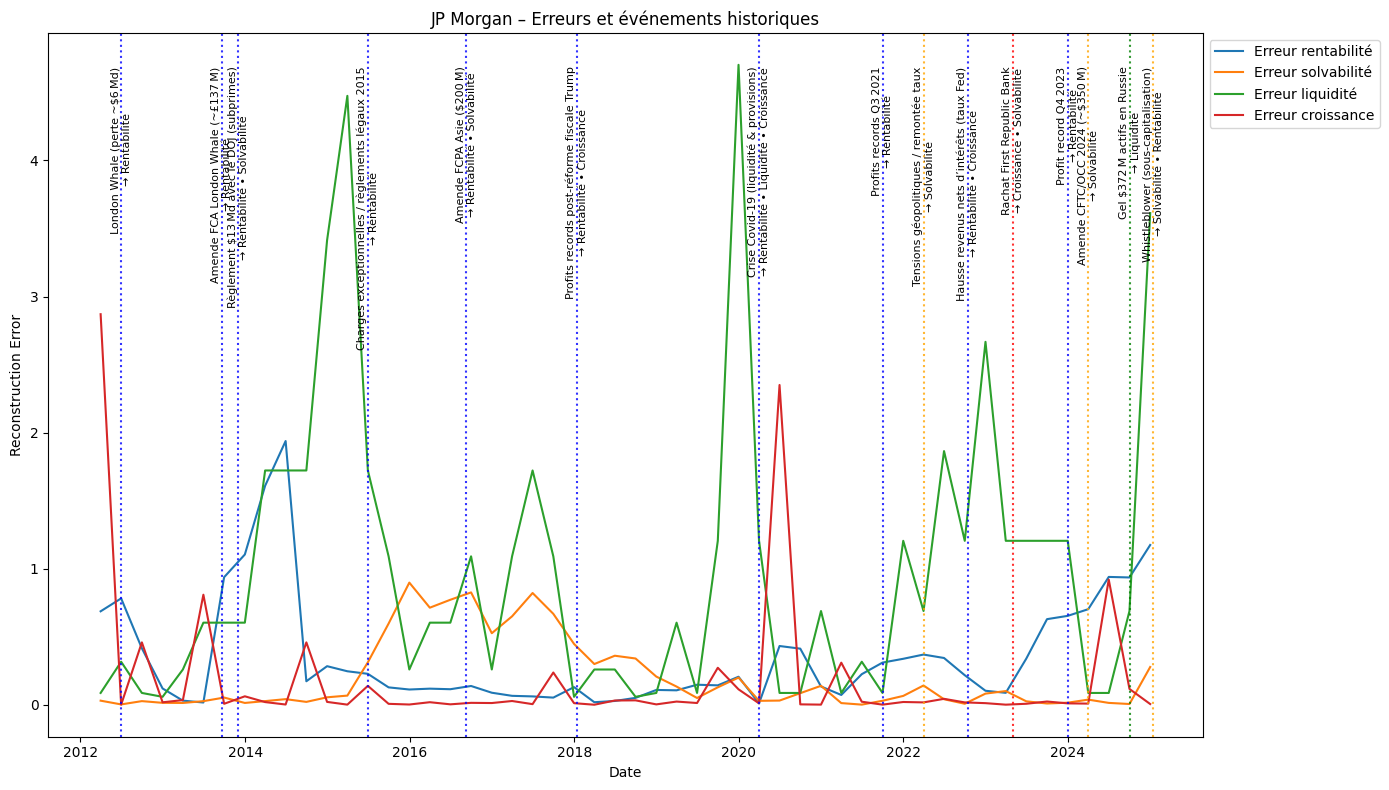

In [42]:
# Define color mapping
target_colors = {
    "rentabilité": "blue",
    "solvabilité": "orange",
    "liquidité": "green",
    "croissance": "red"
}

plt.figure(figsize=(14, 8))

# Plot reconstruction errors
for group in groups:
    plt.plot(df_group_errors['date'], df_group_errors[group], label=f'Erreur {group}')

# Annotate events
for _, row in df_events_jpm.iterrows():
    targets = row['target'].split('/')
    color = target_colors.get(targets[0].strip(), 'gray')  # first target color as main line

    # Vertical event line
    plt.axvline(row['date'], color=color, linestyle=':', alpha=0.8)

    # Annotation with full target list
    impact_label = ' • '.join(t.capitalize() for t in targets)
    plt.text(row['date'], plt.ylim()[1]*0.95, f"{row['event']}\n→ {impact_label}",
             rotation=90, va='top', ha='center', fontsize=8, color='black')


plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('JP Morgan – Erreurs et événements historiques')
plt.xlabel('Date')
plt.ylabel('Reconstruction Error')
plt.tight_layout()
plt.show()


In [49]:
from sklearn.preprocessing import StandardScaler

macro_cols = ["gdp_growth_rate", "interest_rate", "inflation_YoY"]

# Standardisation des variables macro
scaler = StandardScaler()
df_macro_scaled = pd.DataFrame(scaler.fit_transform(df_banco[macro_cols]), columns=macro_cols)
df_macro_scaled["date"] = df_banco["date"].values


In [51]:
# Fusion des erreurs avec les macroéconomiques
df_merged = df_group_errors.merge(df_macro_scaled, on="date", how="inner")


In [54]:
def plot_group_vs_macro(group_name):
    fig, ax1 = plt.subplots(figsize=(14, 5))

    # Erreur du groupe
    ax1.plot(df_merged["date"], df_merged[group_name], label=f"Erreur {group_name}", color='blue')
    ax1.set_ylabel("Erreur de reconstruction", color='blue')

    # Axe secondaire pour les macro variables
    ax2 = ax1.twinx()
    ax2.plot(df_merged["date"], df_merged["gdp_growth_rate"], '--', color='orange', label="Croissance (GDP)")
    ax2.plot(df_merged["date"], df_merged["inflation_YoY"], '--', color='red', label="Inflation")
    ax2.plot(df_merged["date"], df_merged["interest_rate"], '--', color='green', label="Taux d'intérêt")
    ax2.set_ylabel("Variables macro (standardisées)", color='gray')

    # Légende
    fig.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.title(f"{group_name.capitalize()} : erreur vs variables macro")
    plt.tight_layout()
    plt.show()


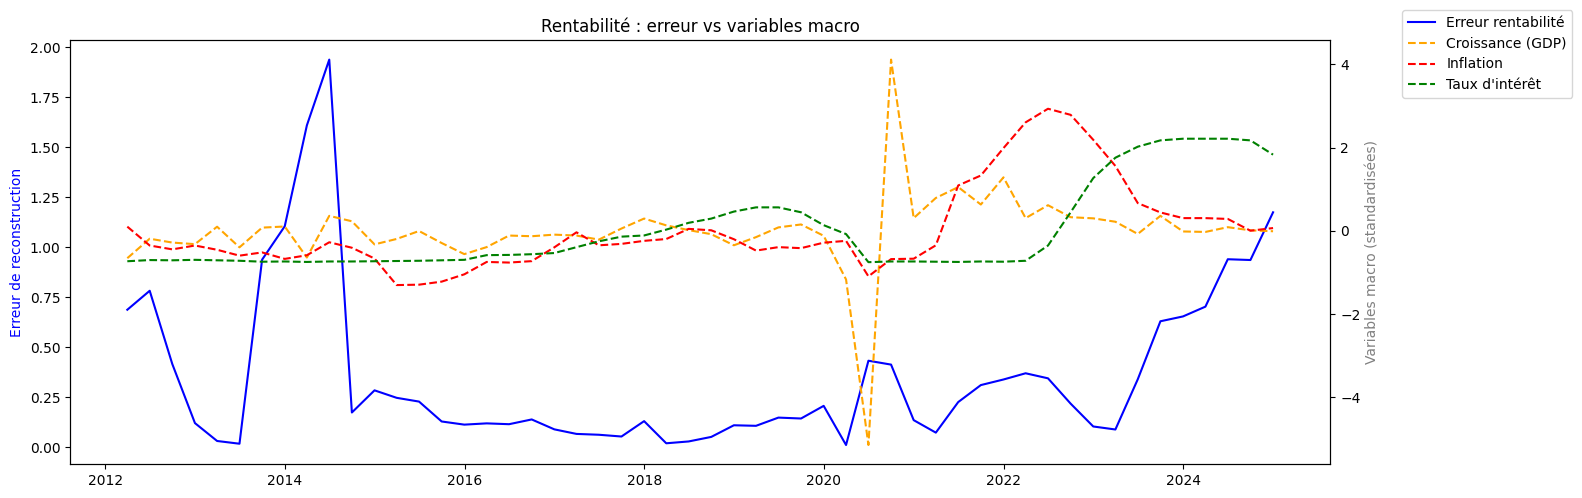

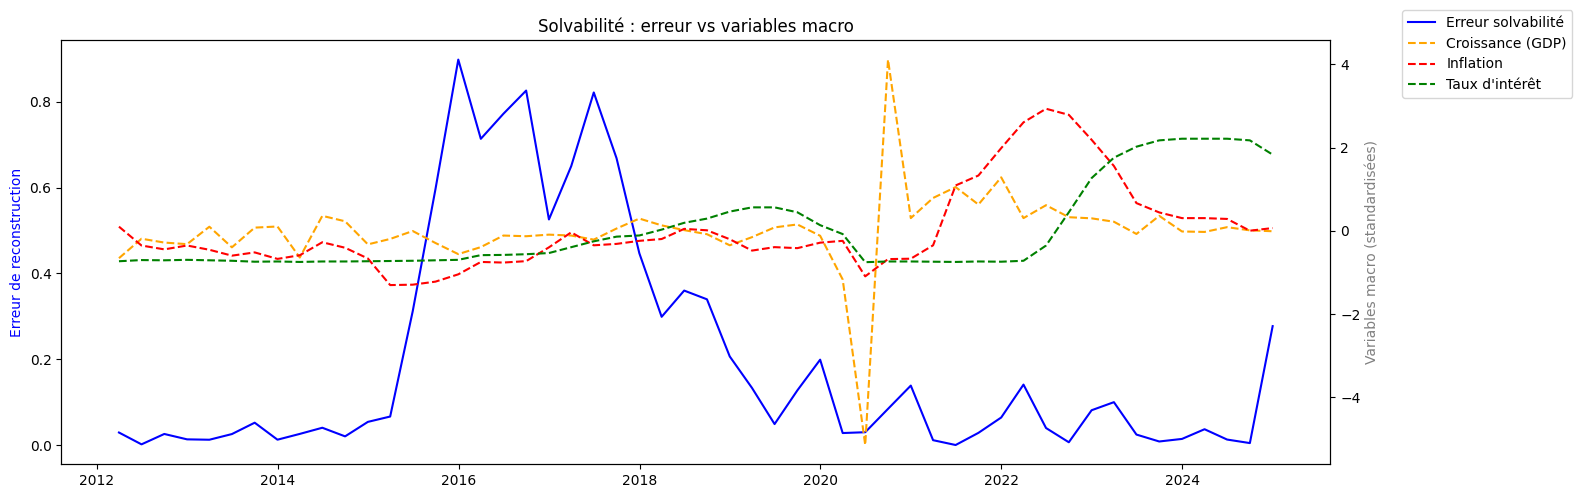

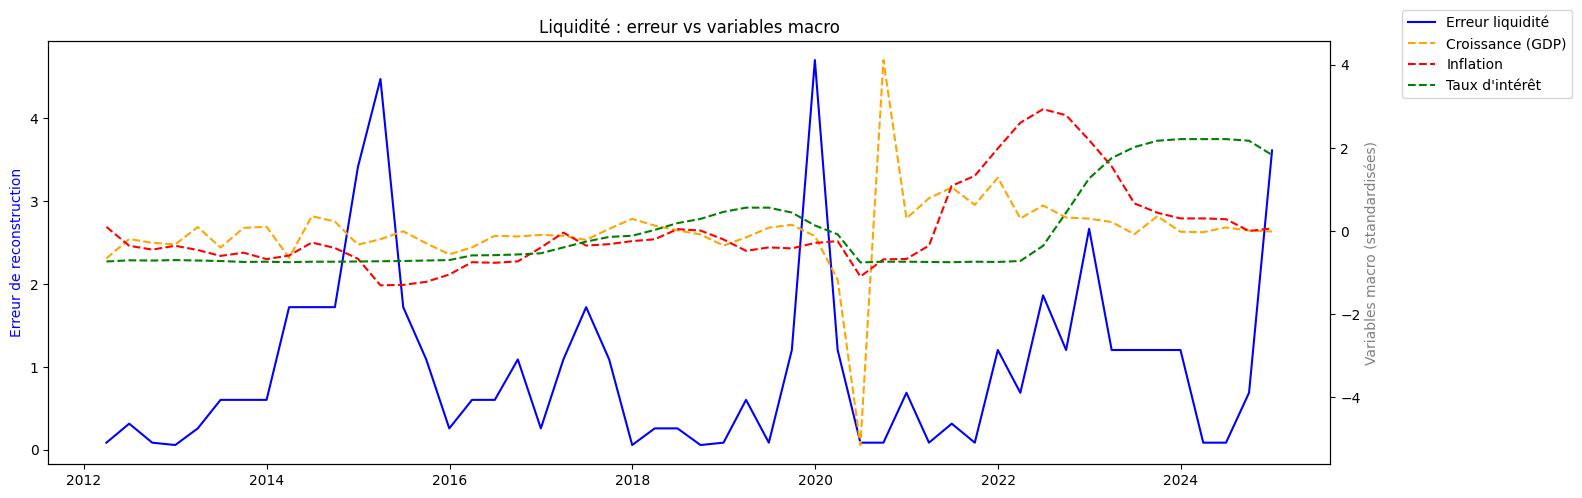

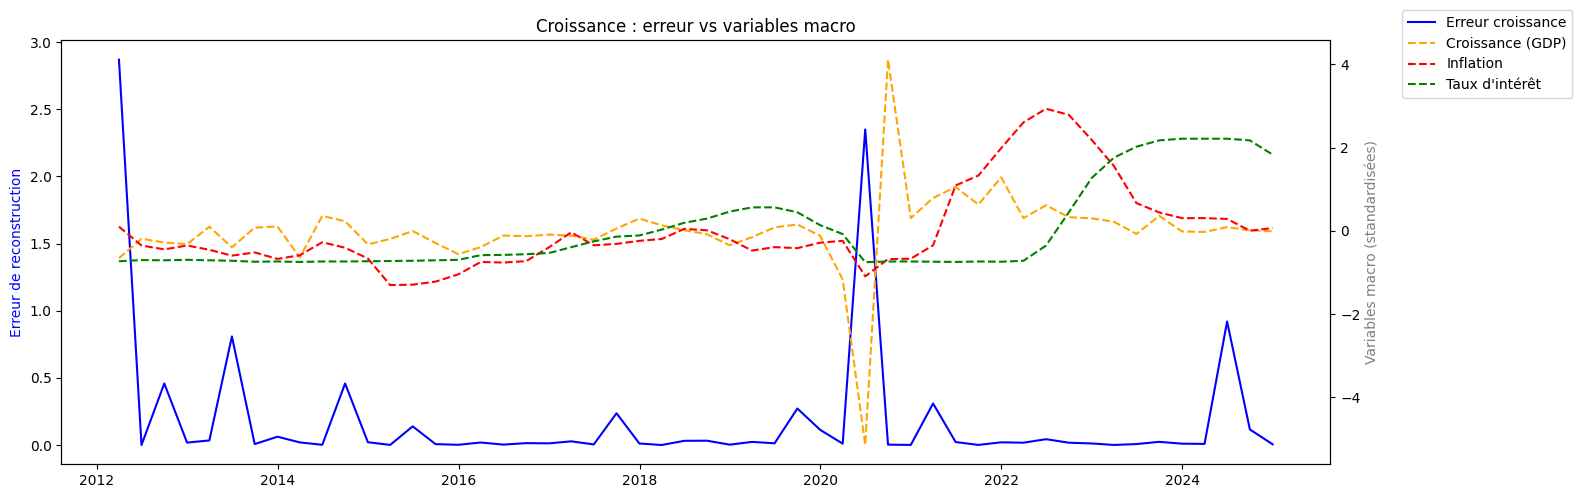

In [56]:
plot_group_vs_macro("rentabilité")
plot_group_vs_macro("solvabilité")
plot_group_vs_macro("liquidité")
plot_group_vs_macro("croissance")


In [79]:
import pandas as pd
import numpy as np

# 1. Fusionner erreurs dans df_group_errors (déjà fait, on le suppose ici)
value_cols = ["rentabilité", "solvabilité", "liquidité", "croissance"]

# 2. Convertir df_group_errors en format long

# Melt format long
df_jpm_long = df_group_errors.melt(
    id_vars=["date", "company"],
    value_vars=value_cols,
    var_name="error_type",
    value_name="reconstruction_error"
)

# Ajouter les colonnes d'anomalie
for col in value_cols:
    df_jpm_long.loc[df_jpm_long["error_type"] == col, "is_anomaly"] = df_group_errors[f"is_anomaly_{col}"].values

# Parser correctement les dates
# Important : vérifier que le format de date est bien %d/%m/%Y
try:
    df_jpm_long["date"] = pd.to_datetime(df_jpm_long["date"], format="%d/%m/%Y")
except:
    df_jpm_long["date"] = pd.to_datetime(df_jpm_long["date"], dayfirst=True, errors="coerce")

# 3. Créer le DataFrame d'événements
jpm_events = [
    {"date":"2012-07-01", "event":"London Whale (perte ~$6 Md)", "target":"rentabilité", "macro": False},
    {"date":"2013-09-19", "event":"Amende FCA London Whale (~£137 M)", "target":"rentabilité", "macro": False},
    {"date":"2013-12-01", "event":"Règlement $13 Md avec le DOJ (subprimes)", "target":"rentabilité/solvabilité", "macro": False},
    {"date":"2015-06-30", "event":"Charges exceptionnelles / règlements légaux 2015", "target":"rentabilité", "macro": False},
    {"date":"2016-09-08", "event":"Amende FCPA Asie ($200 M)", "target":"rentabilité/solvabilité", "macro": False},
    {"date":"2018-01-12", "event":"Profits records post-réforme fiscale Trump", "target":"rentabilité/croissance", "macro": True},
    {"date":"2020-03-31", "event":"Crise Covid -19 (liquidité & provisions)", "target":"rentabilité/liquidité/croissance", "macro": True},
    {"date":"2021-09-30", "event":"Profits records Q3 2021", "target":"rentabilité", "macro": False},
    {"date":"2022-03-31", "event":"Tensions géopolitiques / remontée taux", "target":"solvabilité", "macro": True},
    {"date":"2022-10-15", "event":"Hausse revenus nets d’intérêts (taux Fed)", "target":"rentabilité/croissance", "macro": True},
    {"date":"2023-05-01", "event":"Rachat First Republic Bank", "target":"croissance/solvabilité", "macro": False},
    {"date":"2023-12-31", "event":"Profit record Q4 2023", "target":"rentabilité", "macro": False},
    {"date":"2024-03-31", "event":"Amende CFTC/OCC 2024 (~$350 M)", "target":"solvabilité", "macro": False},
    {"date":"2024-10-02", "event":"Gel $372 M actifs en Russie", "target":"liquidité", "macro": True},
    {"date":"2025-01-14", "event":"Whistleblower (sous-capitalisation)", "target":"solvabilité/rentabilité", "macro": False},
]

df_events = pd.DataFrame(jpm_events)
df_events["date"] = pd.to_datetime(df_events["date"])

# 4. Convertir en trimestre pour correspondance

# Format trimestre
df_jpm_long["quarter"] = df_jpm_long["date"].dt.to_period("Q").dt.to_timestamp()
df_events["quarter"] = df_events["date"].dt.to_period("Q").dt.to_timestamp()

# 5. Fusionner avec les événements

df_merged = df_jpm_long.merge(
    df_events[["quarter", "event", "macro"]],
    on="quarter",
    how="left"
)

# 6. Résultat final affiché
final_cols = ["date", "company", "error_type", "is_anomaly", "event", "macro"]
print(df_merged[final_cols].head(20))


         date          company   error_type is_anomaly  \
0  2012-03-31  JP Morgan Chase  rentabilité      False   
1  2012-06-30  JP Morgan Chase  rentabilité      False   
2  2012-09-30  JP Morgan Chase  rentabilité      False   
3  2012-12-31  JP Morgan Chase  rentabilité      False   
4  2013-03-31  JP Morgan Chase  rentabilité      False   
5  2013-06-30  JP Morgan Chase  rentabilité      False   
6  2013-09-30  JP Morgan Chase  rentabilité      False   
7  2013-12-31  JP Morgan Chase  rentabilité      False   
8  2014-03-31  JP Morgan Chase  rentabilité       True   
9  2014-06-30  JP Morgan Chase  rentabilité       True   
10 2014-09-30  JP Morgan Chase  rentabilité      False   
11 2014-12-31  JP Morgan Chase  rentabilité      False   
12 2015-03-31  JP Morgan Chase  rentabilité      False   
13 2015-06-30  JP Morgan Chase  rentabilité      False   
14 2015-09-30  JP Morgan Chase  rentabilité      False   
15 2015-12-31  JP Morgan Chase  rentabilité      False   
16 2016-03-31 

In [80]:
def classify_event(row):
    if pd.isna(row["event"]):
        return "aucun"
    elif row["macro"]:
        return "externe"
    else:
        return "interne"

df_merged["event_type"] = df_merged.apply(classify_event, axis=1)


In [83]:
# Nouvelle classification simplifiée
def classify_origin(row):
    if pd.isna(row["event"]):
        return "interne non identifié"
    else:
        return "expliqué"

df_merged["origine"] = df_merged.apply(classify_origin, axis=1)

# On filtre uniquement les anomalies
df_anomalies = df_merged[df_merged["is_anomaly"] == True]


In [85]:
pivot_count = df_anomalies.pivot_table(
    index="error_type",
    columns="origine",
    values="date",
    aggfunc="count",
    fill_value=0
)

print("📊 Nombre d’anomalies par type :")
print(pivot_count)


📊 Nombre d’anomalies par type :
origine      expliqué  interne non identifié
error_type                                  
croissance          0                      3
liquidité           1                      2
rentabilité         1                      2
solvabilité         1                      2


Autoencoder with macro

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam

def train_autoencoder(X, encoding_dim=2, epochs=100, batch_size=8):
    input_dim = X.shape[1]
    input_layer = Input(shape=(input_dim,))

    # Encodeur
    encoded = Dense(encoding_dim * 2, activation='relu')(input_layer)
    encoded = Dense(encoding_dim, activation='relu')(encoded)

    # Décodeur
    decoded = Dense(encoding_dim * 2, activation='relu')(encoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    autoencoder.fit(X, X, epochs=epochs, batch_size=batch_size, verbose=0)
    return autoencoder


In [ ]:
from sklearn.preprocessing import StandardScaler

# Exemples de groupes
groups = {
    "rentabilité": ["ROE", "ROA", "net_margin"],  # résultats internes
    "solvabilité": ["debt_to_equity", "current_ratio", "interest_rate"],  # les taux influencent la dette
    "liquidité": ["cash_ratio", "gdp_growth_rate"],  # croissance stimule la capacité à générer du cash
    "croissance": ["revenue_growth", "inflation_YoY"]  # inflation = pression sur la marge
}

autoencoders = {}
reconstruction_errors = {}

for group_name, cols in groups.items():
    print(f"▶️ Training AutoEncoder for {group_name}")

    # Normalisation
    scaler = StandardScaler()
    X_group = scaler.fit_transform(df_banco[cols])

    # Entraînement
    ae = train_autoencoder(X_group, encoding_dim=min(2, len(cols)))
    autoencoders[group_name] = ae

    # Reconstruction
    X_rec = ae.predict(X_group)
    mse = np.mean(np.square(X_group - X_rec), axis=1)
    reconstruction_errors[group_name] = mse


▶️ Training AutoEncoder for rentabilité
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
▶️ Training AutoEncoder for solvabilité
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
▶️ Training AutoEncoder for liquidité
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
▶️ Training AutoEncoder for croissance
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


In [ ]:
# Fusion dans un DataFrame
df_group_errors = pd.DataFrame(reconstruction_errors)
df_group_errors["date"] = df_banco["date"].values
df_group_errors["company"] = df_banco["company"].values

# Ajoute une colonne "anomalie_detectée"
for group in groups:
    threshold = np.percentile(df_group_errors[group], 95)
    df_group_errors[f"is_anomaly_{group}"] = df_group_errors[group] > threshold

# Aperçu
print(df_group_errors.head())

   rentabilité  solvabilité  liquidité  croissance       date  \
0     0.620232     0.108420   0.338398    2.670259 2012-03-31   
1     0.681800     0.038069   0.126353    0.787621 2012-06-30   
2     0.344343     0.012751   0.106998    0.615192 2012-09-30   
3     0.090103     0.020998   0.022303    0.170864 2012-12-31   
4     0.013340     0.083188   0.046159    0.043240 2013-03-31   

           company  is_anomaly_rentabilité  is_anomaly_solvabilité  \
0  JP Morgan Chase                   False                   False   
1  JP Morgan Chase                   False                   False   
2  JP Morgan Chase                   False                   False   
3  JP Morgan Chase                   False                   False   
4  JP Morgan Chase                   False                   False   

   is_anomaly_liquidité  is_anomaly_croissance  
0                 False                   True  
1                 False                  False  
2                 False                  

In [ ]:
import pandas as pd

df_events_jpm = pd.DataFrame([
    {"date":"2012-07-01", "event":"London Whale (perte ~\$6 Md)", "target":"rentabilité"},
    {"date":"2013-09-19", "event":"Amende FCA London Whale (~£137 M)", "target":"rentabilité"},
    {"date":"2015-06-30", "event":"Charges exceptionnelles / règlements légaux 2015", "target":"rentabilité"},
    {"date":"2020-03-31", "event":"Crise Covid‑19 (liquidité & provisions)", "target":"liquidité"},
    {"date":"2021-09-30", "event":"Profits records Q3 2021", "target":"rentabilité"},
    {"date":"2022-03-31", "event":"Tensions géopolitiques / remontée taux", "target":"solvabilité"},
    {"date":"2023-12-31", "event":"Profit record Q4 2023", "target":"rentabilité"},
    {"date":"2024-03-31", "event":"Amende CFTC/OCC 2024 (~\$350 M)", "target":"solvabilité"},
    {"date":"2024-10-02", "event":"Gel 372 M\$ Russie", "target":"liquidité"},
    {"date":"2025-01-14", "event":"Whistle‑blower (sous‑capitalisation)", "target":"solvabilité"},
])
df_events_jpm['date'] = pd.to_datetime(df_events_jpm['date'])


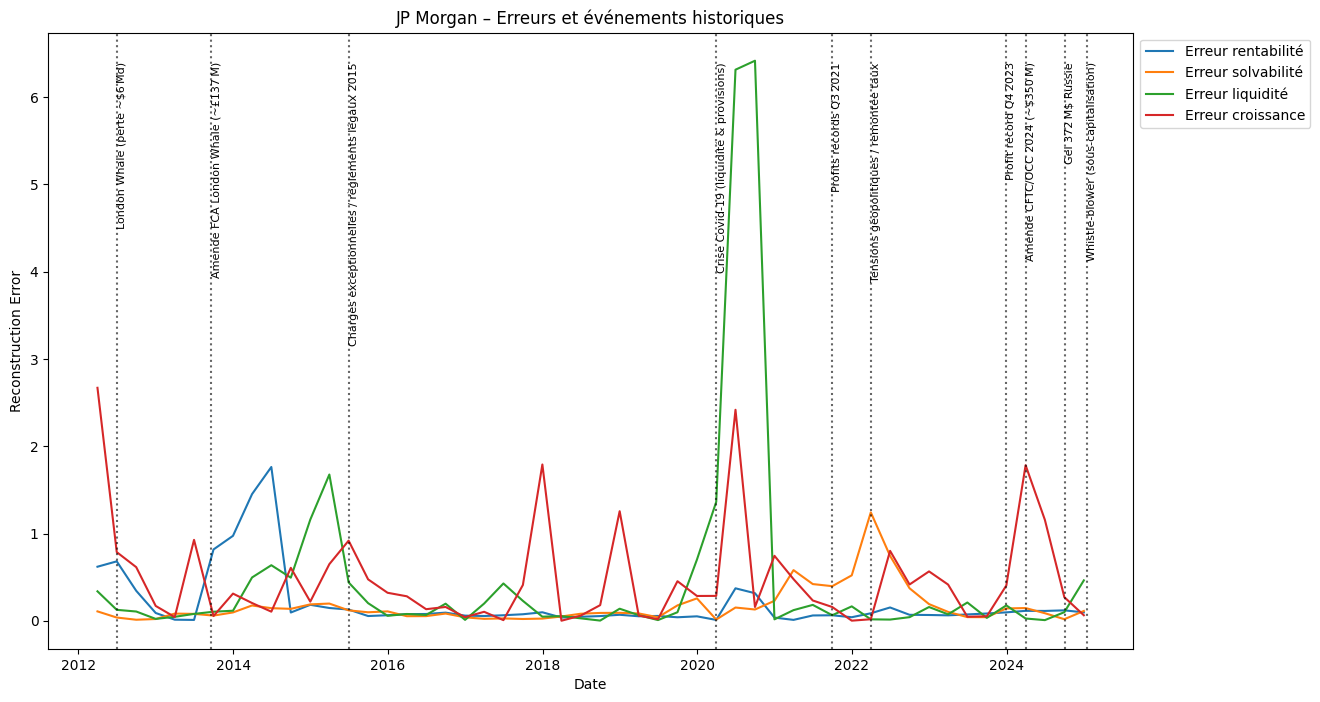

In [ ]:
plt.figure(figsize=(14,8))
for group in groups:
    plt.plot(df_group_errors['date'], df_group_errors[group], label=f'Erreur {group}')

for _, row in df_events_jpm.iterrows():
    plt.axvline(row['date'], color='k', linestyle=':', alpha=0.6)
    plt.text(row['date'], plt.ylim()[1]*0.95, row['event'], rotation=90, va='top', fontsize=8)

plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('JP Morgan – Erreurs et événements historiques')
plt.xlabel('Date')
plt.ylabel('Reconstruction Error')
plt.show()
